# Modular version of rat tumors code

This is a modularized version of the rat tumor analysis, factored into reusable functions.

## Setup

Grab packages

In [1]:
library(ggplot2)
library(plyr)
library(tidyverse)
library(rstan)

Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
library(doParallel)
registerDoParallel()

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel


In [3]:
rstan_options(auto_write=TRUE)
options(mc.cores=parallel::detectCores())

Set options

In [4]:
options(repr.matrix.max.rows = 20)

Load the data:

In [5]:
rat.data = read_csv("rats.csv")
summary(rat.data)

Parsed with column specification:
cols(
  Infected = col_integer(),
  Total = col_integer()
)


    Infected          Total      
 Min.   : 0.000   Min.   :10.00  
 1st Qu.: 1.000   1st Qu.:19.00  
 Median : 3.000   Median :20.00  
 Mean   : 3.761   Mean   :24.49  
 3rd Qu.: 5.000   3rd Qu.:22.50  
 Max.   :16.000   Max.   :52.00  

In [6]:
rat.data

Infected,Total
0,20
0,20
0,20
0,20
0,20
0,20
0,20
0,19
0,19
0,19


## The Model

In this data set, for each experiment $j$, we have two observations: $c_j$, the number of infected rats, and $n_j$, the number of rats.

We model the data as having an infection rate $\theta_j$ for each experiment.  We want to make inferences about the distribution of $\theta_j$.

In more detail, we use the following model:

- $c_j \sim \mathrm{Bin}(n_j,\theta_j)$
- $\theta_j \sim \mathrm{Beta}(\alpha, \beta)$

For the purposes of notational simplicity theorem, we parameterize our model parameters as $\phi = (\alpha, \beta)$.

Therefore, we have the goal of computing $P(\phi,\mathbf{\theta}|\mathbf{c})$ given $\mathbf{c}$ and our model / likelihood function $P(\mathbf{c},\mathbf{\theta}|\phi) = \prod_j P(c_j,\theta_j|\phi_j) = \prod_j P(c_j|\theta_j)P(\theta_j|\phi_j)$.

The final derivation, as per Eq. 5.8 in Gelman et al., is 

$$P(\alpha, \beta|\mathrm{y}) \propto P(\alpha, \beta) \prod_j \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + c_j)\Gamma(\beta+n_j-c_j)}{\Gamma(\alpha+\beta+n_j)}$$

We will compute this log-transformed.

So we define the log likelihood function for this model. It will take as input $\alpha$ and $\beta$ vectors (which should be the same length), and return the log likelihood of each $(\alpha, \beta)$ value given the $\mathbf{c}$ and $\mathbf{n}$ vectors:

In [7]:
model.loglike = function(alpha, beta, cs, ns) {
    base = lgamma(alpha + beta) - lgamma(alpha) - lgamma(beta)
    data = mapply(a=alpha, b=beta, FUN=function(a, b) {
        sum(lgamma(a + cs) + 
                lgamma(b + ns - cs) - 
                lgamma(a + b + ns))
    })
    nrow(rat.data) * base + data
}

We're also going to use the diffuse prior from Equation 5.9:

$$P(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$$

We will not worry about the constant, since we care about *relative* densities.

In [8]:
model.prior = prior = function(alpha, beta) {
    (alpha + beta) ^ (-5 / 2)
}

## Densities in Transformed Space

We want to be able to compute and reason about the probability density at various $\alpha$ and $\beta$ values. However, raw $\alpha \times \beta$ space is not very convenient, so we will plot instead over $x = \mathrm{log}(\frac{\alpha}{\beta})$ and $y = \mathrm{log}(\alpha + \beta)$, yielding:

$$\begin{align*}
x & = \mathrm{log}(\frac{\alpha}{\beta}) \\
y & = \mathrm{log}(\alpha + \beta) \\
\alpha & = e^x \beta \\
\beta & = \frac{e^y}{e^x + 1}
\end{align*}$$

In [9]:
par.beta = function(x, y) {
    exp(y) / (exp(x) + 1)
}
par.alpha = function(x, y) {
    exp(x) * par.beta(x, y)
}

Given ranges (really, sequences) of $x$ and $y$ values, we want to compute the probability density.  We call this `xydensity` because it is the density at $(x, y)$.  It returns the density at each pair $(x, y)$, taking the Cartesian product of the `x` and `y` vectors. The `counts` and `totals` parameters ($\mathbf{c}$ and $\mathbf{n}$) are also vectors, but the value for each $(x,y)$ poitn depends on the entire $\mathbf{c}$ and $\mathbf{n}$ vectors.

In [10]:
xydensity = function(x, y, counts, totals, prior=model.prior, loglike=model.loglike) {
    expand.grid(x=x, y=y) %>%
        mutate(alpha = par.alpha(x, y),
               beta = par.beta(x, y)) %>%
        mutate(logPrior = log(prior(alpha, beta)),
               logLike = loglike(alpha, beta, counts, totals),
               rawLogPost = logPrior + logLike) %>%
        mutate(logJacobian = log(alpha) + log(beta),
               logPost = rawLogPost + logJacobian)
}

Let's now try it:

In [11]:
dens.points = xydensity(x=sample(seq(-2.3, -1.3, 0.005), 100),
                        y=sample(seq(1, 5, 0.005), 100),
                        counts=rat.data$Infected, totals=rat.data$Total)
dens.points

x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost
-1.405,4.28,14.233092,58.00735,-10.7,-747.8008,-758.5008,6.716139,-751.7847
-1.905,4.28,9.358288,62.88215,-10.7,-737.5867,-748.2867,6.377525,-741.9092
-1.395,4.28,14.347727,57.89271,-10.7,-748.4699,-759.1699,6.722183,-752.4477
-2.255,4.28,6.856994,65.38345,-10.7,-751.5870,-762.2870,6.105538,-756.1814
-1.300,4.28,15.471375,56.76906,-10.7,-755.8795,-766.5795,6.777983,-759.8015
-1.995,4.28,8.649268,63.59117,-10.7,-739.8336,-750.5336,6.309949,-744.2236
-1.335,4.28,15.050104,57.19034,-10.7,-752.9243,-763.6243,6.757770,-756.8666
-1.380,4.28,14.520979,57.71946,-10.7,-749.5123,-760.2123,6.731189,-753.4812
-1.780,4.28,10.424522,61.81592,-10.7,-736.2991,-746.9991,6.468322,-740.5308
-1.600,4.28,12.135066,60.10537,-10.7,-738.6894,-749.3894,6.592199,-742.7972


In [12]:
dim(dens.points)

[1] 10000     9

In [13]:
summary(dens.points %>% select(rawLogPost, logLike, logPost))

   rawLogPost        logLike          logPost      
 Min.   :-776.0   Min.   :-763.5   Min.   :-768.5  
 1st Qu.:-751.3   1st Qu.:-743.9   1st Qu.:-747.3  
 Median :-746.0   Median :-739.2   Median :-742.8  
 Mean   :-747.4   Mean   :-740.2   Mean   :-743.8  
 3rd Qu.:-742.0   3rd Qu.:-735.6   3rd Qu.:-739.1  
 Max.   :-737.0   Max.   :-730.3   Max.   :-733.8  

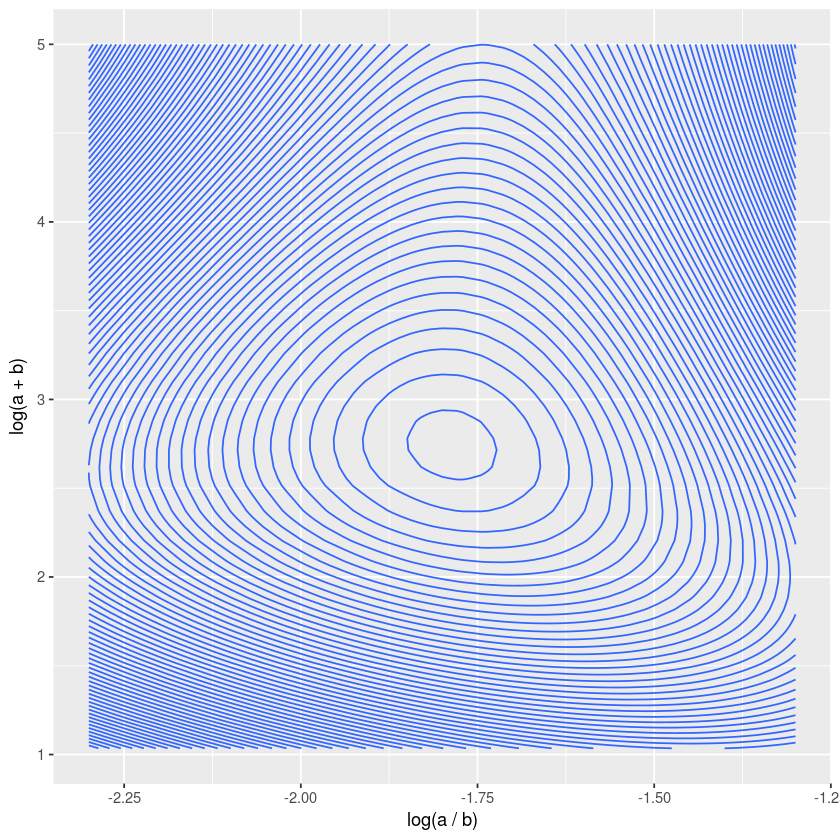

In [14]:
ggplot(dens.points) +
    aes(x=x, y=y, z=logPost) +
    geom_contour(binwidth=0.5) +
    xlab("log(a / b)") +
    ylab("log(a + b)")

## Inference for Parameter Values

With the model in place, we want to use the computed point densities to do some esimation of the posterior distributions.

In [15]:
expvals = function(dens) {
    normPost = dens$logPost - max(dens$logPost)
    alpha = sum(dens$alpha * exp(normPost)) / sum(exp(normPost))
    beta = sum(dens$beta * exp(normPost)) / sum(exp(normPost))
    x = log(alpha / beta)
    y = log(alpha + beta)
    mean = alpha / (alpha + beta)
    data.frame(alpha=alpha, beta=beta, x=x, y=y, mean=mean)
}

In [16]:
expvals(dens.points)

alpha,beta,x,y,mean
2.406424,14.37326,-1.787228,2.820169,0.143413


## MAP estimate

We want to find the *maximum* value of the log posterior, so that we can use it later for normalization in the integral.  The `optim` function seems perfect for this!

In [17]:
model.map = optim(c(1, 1), function(pars) {
    alpha = pars[1]
    beta = pars[2]
    log(model.prior(alpha, beta)) + model.loglike(alpha, beta, rat.data$Infected, rat.data$Total)
}, control=list(fnscale=-1))
model.map

$par
[1]  1.82629 10.84766

$value
[1] -737.0054

$counts
function gradient 
      71       NA 

$convergence
[1] 0

$message
NULL


## Integral Inference for the Posterior

First, we will write a function to compute the probability density of a particular $\theta$, as an integral $P(\theta|\mathbf{y}) = \iint P(\theta|\alpha,\beta)P(\alpha,\beta|\mathbf{y}) \, \mathrm{d}\alpha \mathrm{d}\beta$.

This function is over `theta` (it will return a vector of densities, one corresponding to each value of `theta`).  The `norm` parameter is a normalizing constant used to make the log likelihoods exponentiable within the limits of floating point accuracy; a value a little less than the maximum log likelihood computed by the `xydensity` function is a good choice.

In [18]:
model.theta.post = function(theta, logScale, counts, totals, prior=model.prior, loglike=model.loglike,
                            parallel=!identical(Sys.info()[["sysname"]], "Windows")) {
    aaply(theta, 1, function(thv) {
        integrate(function(beta) {
            aaply(beta, 1, function(bv) {
                integrate(function(alpha) {
                    ll = loglike(alpha, bv, counts, totals)
                    like = exp(ll - logScale)
                    pth = dbeta(thv, alpha, bv)
                    pth * prior(alpha, bv) * like
                }, 0, Inf, rel.tol = 0.001)$value
                })
            }, 0, Inf, rel.tol = 0.001)$value
    }, .parallel=parallel)
}

What's our maximum density? We'll use that as a starting point for scaling.

In [19]:
model.map$value

[1] -737.0054

Let's compute; we do a second normalization to account for the fact that we are computing on intervals of 0.001, to try to make the area under the curve sum to 1.  This computation takes a little while.

In [20]:
theta.post = data.frame(Theta=seq(0.01, 0.99, 0.005)) %>%
    mutate(RawPostDens = model.theta.post(Theta, model.map$value + 1,
                                          rat.data$Infected, rat.data$Total)) %>%
    mutate(PostDens = RawPostDens / sum(RawPostDens * 0.005))

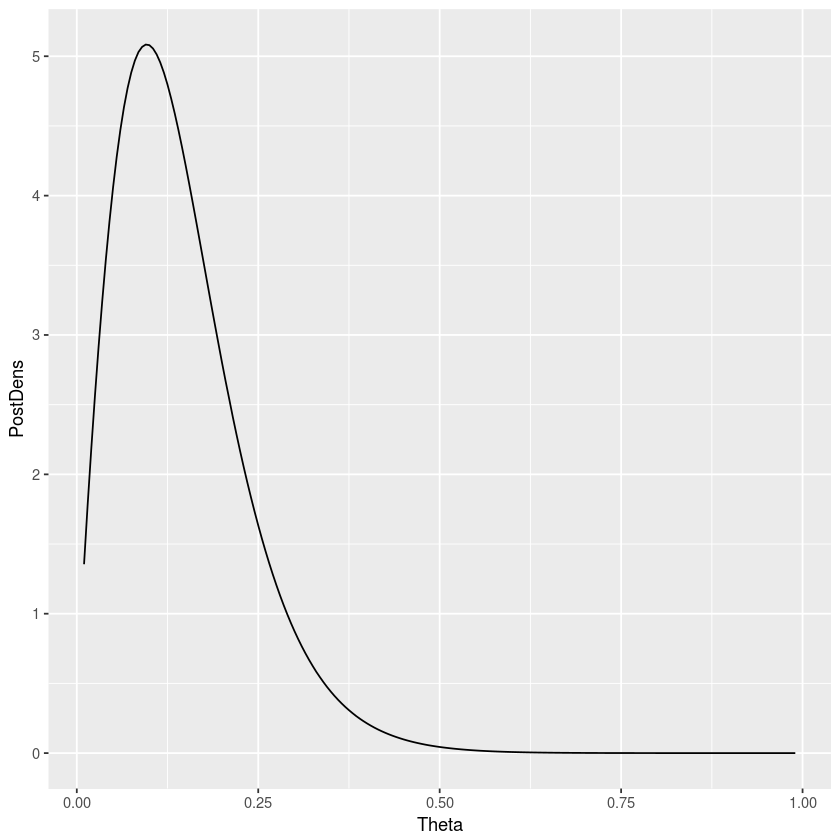

In [21]:
ggplot(theta.post) +
    aes(x=Theta, y=PostDens) +
geom_line()

## Monte Carlo Simulation of the Posterior

Now we are going to use STAN to conduct an MCMC simulation of the posterior distribution.

In [18]:
writeLines(readLines("ratmodel.stan"))

data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0,upper=1> theta[J];
}
model {
    theta ~ beta(alpha, beta);
    y ~ binomial(n, theta);
}


In [20]:
rat_fit = stan(file="ratmodel.stan", data=list(J=nrow(rat.data), y=rat.data$Infected, n=rat.data$Total),
               iter=2000, chains=4, control=list(adapt_delta=0.99))

Warning message:
“There were 76 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 30 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [21]:
print(rat_fit)

Inference for Stan model: ratmodel.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean  se_mean       sd    2.5%     25%     50%     75%    97.5%
alpha      2098.59  2383.60  4957.45    1.65    2.61    3.67   27.73 17130.45
beta      10124.90 11645.87 23651.40    9.75   15.84   22.16  173.69 81715.78
theta[1]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[2]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[3]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[4]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[5]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[6]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[7]      0.10     0.03     0.05    0.01    0.05    0.09    0.15     0.18
theta[8]      0.10     0.03     0.05    0.02    0.06    0.09    0.

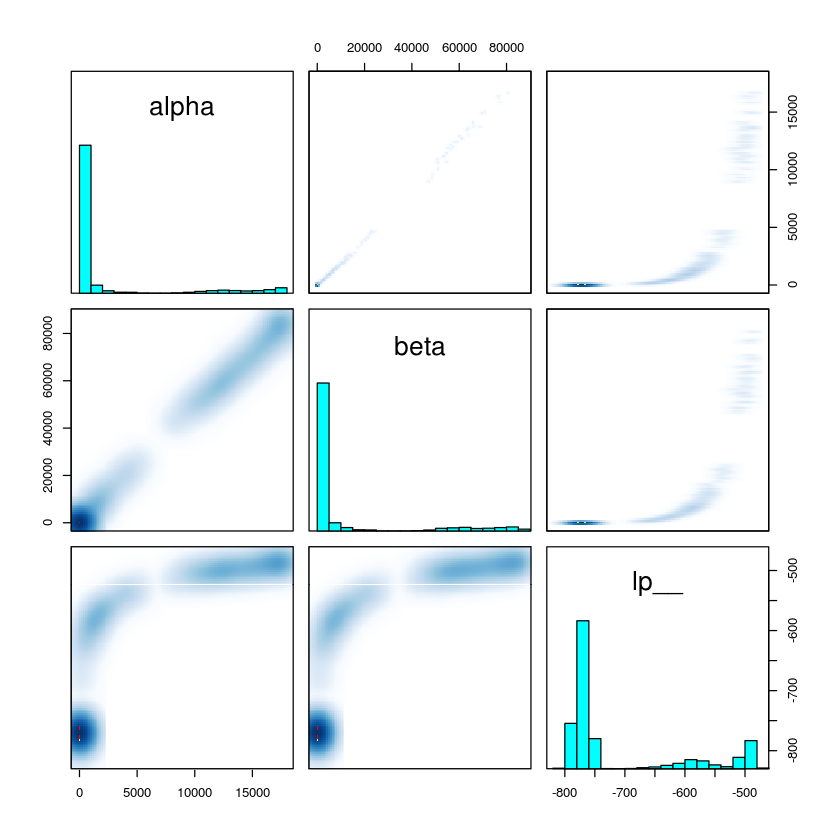

In [22]:
pairs(rat_fit, pars=c("alpha", "beta", "lp__"))

In [23]:
rat_sim = rstan::extract(rat_fit, permuted=TRUE)

In [24]:
n_sims = length(rat_sim$lp__)
n_sims

[1] 4000

In [25]:
theta_sims = data_frame(alpha=rat_sim$alpha, beta=rat_sim$beta) %>%
    mutate(Theta=rbeta(n(), alpha, beta))

In [26]:
summary(theta_sims)

     alpha                beta              Theta         
 Min.   :    0.996   Min.   :    6.13   Min.   :0.002141  
 1st Qu.:    2.611   1st Qu.:   15.84   1st Qu.:0.102461  
 Median :    3.673   Median :   22.16   Median :0.152477  
 Mean   : 2098.586   Mean   :10124.90   Mean   :0.148635  
 3rd Qu.:   27.729   3rd Qu.:  173.69   3rd Qu.:0.176309  
 Max.   :17826.122   Max.   :86848.38   Max.   :0.509650  

In [27]:
theta_dens = density(theta_sims$Theta)

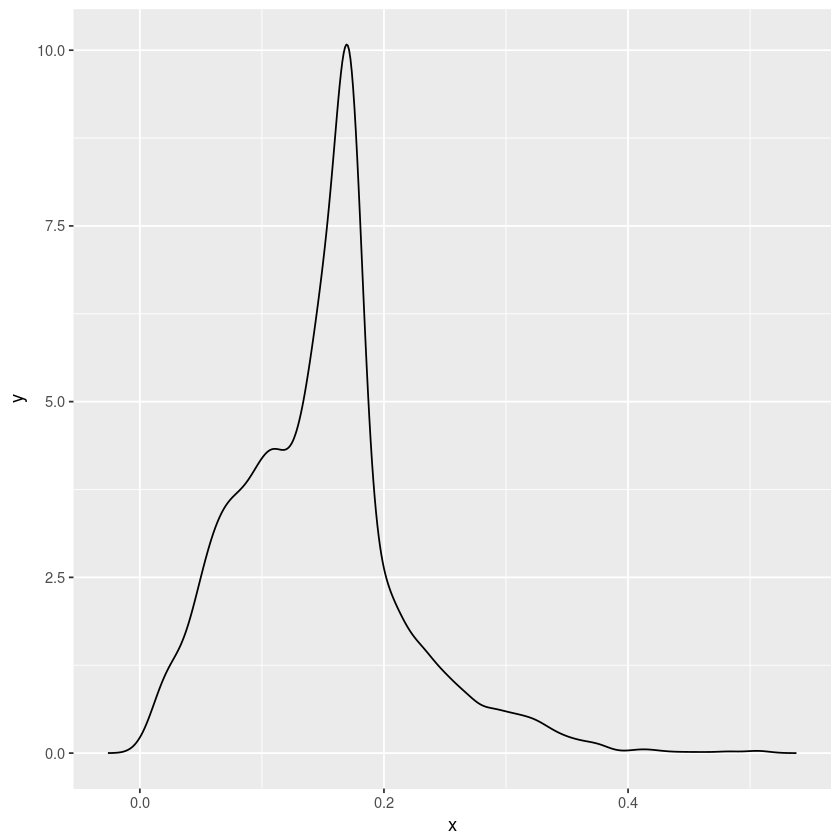

In [28]:
ggplot(data_frame(x=theta_dens$x, y=theta_dens$y)) +
    aes(x, y) +
    geom_line()

### Use priors & reparameterization

In [29]:
writeLines(readLines("ratxmodel.stan"))

data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0,upper=1> phi;
    real<lower=0.1> lambda;
    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    alpha = lambda * phi;
    beta = lambda * (1 - phi);
}
model {
    phi ~ beta(1,1);
    lambda ~ pareto(0.1, 1.5);
    theta ~ beta(alpha, beta);
    y ~ binomial(n, theta);
}


In [51]:
ratx_fit = stan(file="ratxmodel.stan",
                data=list(J=nrow(rat.data), y=rat.data$Infected, n=rat.data$Total),
                iter=2000, chains=4, control=list(adapt_delta=0.99))

hash mismatch so recompiling; make sure Stan code ends with a blank line


In [52]:
print(ratx_fit)

Inference for Stan model: ratxmodel.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
phi          0.14    0.00 0.01    0.12    0.14    0.14    0.15    0.17  3290
lambda      14.94    0.19 5.09    7.87   11.35   14.07   17.55   27.21   691
theta[1]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[2]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[3]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[4]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[5]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.17  4000
theta[6]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[7]     0.06    0.00 0.04    0.01    0.03    0.05    0.08    0.16  4000
theta[8]     0.06    0.00 0.04    0.01    0.03    0.05    0.09    0.16  400

In [36]:
ratx_sim = rstan::extract(ratx_fit, permuted=TRUE)

In [37]:
n_sims = length(ratx_sim$lp__)
n_sims

[1] 4000

In [38]:
thetax_sims = data_frame(alpha=ratx_sim$alpha, beta=ratx_sim$beta) %>%
    mutate(Theta=rbeta(n(), alpha, beta))

In [39]:
summary(thetax_sims)

     alpha             beta            Theta          
 Min.   :0.7488   Min.   : 4.179   Min.   :0.0002697  
 1st Qu.:1.6366   1st Qu.: 9.655   1st Qu.:0.0725437  
 Median :2.0138   Median :11.967   Median :0.1277092  
 Mean   :2.1246   Mean   :12.589   Mean   :0.1441277  
 3rd Qu.:2.4784   3rd Qu.:14.725   3rd Qu.:0.1963121  
 Max.   :6.5699   Max.   :38.993   Max.   :0.7375433  

In [40]:
thetax_dens = density(thetax_sims$Theta)

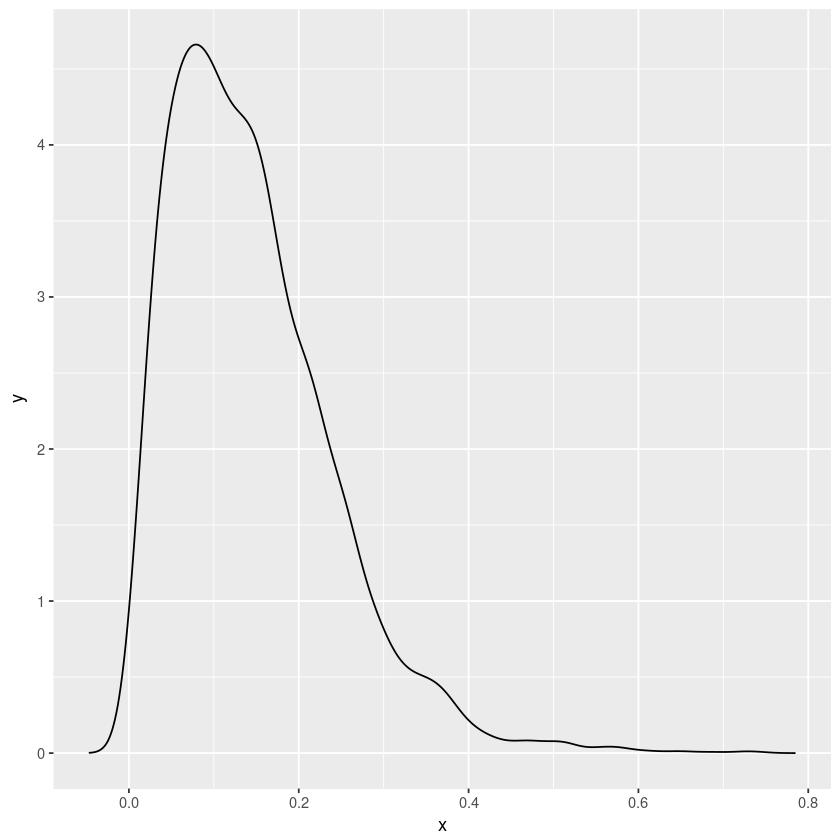

In [41]:
ggplot(data_frame(x=thetax_dens$x, y=thetax_dens$y)) +
    aes(x, y) +
    geom_line()

## Unified Plots

In [42]:
posteriors = bind_rows(Integrated=select(theta.post, Theta, Density=PostDens),
                       MCMC=data_frame(Theta=theta_dens$x, Density=theta_dens$y),
                       MCMC_RP=data_frame(Theta=thetax_dens$x, Density=thetax_dens$y),
                       .id="Method")

ERROR: Error in select(theta.post, Theta, Density = PostDens): object 'theta.post' not found


In [43]:
ggplot(posteriors) +
    aes(x=Theta, y=Density, color=Method) +
    geom_line()

ERROR: Error in ggplot(posteriors): object 'posteriors' not found
